In [1]:
import snap
import numpy as np
import csv

from itertools import permutations
from matplotlib import pyplot as plt

## 1. Read in the Graphs

In [2]:
FILEPATH = "dataset/edges/"

In [3]:
dir_Graph_dict = {}
undir_Graph_dict = {}
for i in range(1, 915):
    G_dir = snap.PNEANet.New()
    G_undir = snap.PNEANet.New() 
    file_name = FILEPATH + str(i) + "_edges.txt"
    firstline = True
    try:
        with open(file_name) as csv_file:
            edge_reader = csv.reader(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            edge_count = 0
            undir_edge_count = 0
            for row in edge_reader:
                if firstline:
                    firstline = False
                    continue
                if i == 814:
                    print row[0]
                if not G_dir.IsNode(int(row[0])):
                    G_dir.AddNode(int(row[0]))
                if not G_dir.IsNode(int(row[1])):
                    G_dir.AddNode(int(row[1]))
                for _ in range(int(float(row[2]))):
                    G_dir.AddEdge(int(row[0]), int(row[1]), edge_count)
                    edge_count += 1
                    G_dir.AddEdge(int(row[1]), int(row[0]), edge_count)
                    edge_count += 1
                if not G_undir.IsNode(int(row[0])):
                    G_undir.AddNode(int(row[0]))
                if not G_undir.IsNode(int(row[1])):
                    G_undir.AddNode(int(row[1]))
                for _ in range(int(float(row[2]))):
                    G_undir.AddEdge(int(row[0]), int(row[1]), undir_edge_count)
                    undir_edge_count += 1
        dir_Graph_dict[i] = G_dir
        undir_Graph_dict[i] = G_undir
    except IOError:
        continue

5005819


## 2. Get Basic Network Properties

In [4]:
def get_degree(G, G_undir):
    # return sum of degree, max degree, and avg degree
    ret = 0
    cnt = 0
    max_deg = 0
    for NI in G_undir.Nodes():
        ret += NI.GetOutDeg()
        max_deg = max(NI.GetOutDeg(), max_deg)
        cnt += 1
    return ret, max_deg, ret * 1.0 / cnt

In [5]:
def get_max_of_shortest_path_length(G, G_undir):
    return snap.GetBfsFullDiam(G_undir, 10000, False)

In [6]:
def get_clustering_coefficient(G, G_undir):
    return snap.GetClustCf(G, -1)

In [7]:
def get_density(G, G_undir):
    return G_undir.GetEdges() * 1.0 /G_undir.GetNodes()

In [8]:
def get_avg_shortest_path_length(G, G_undir):
    G_new = snap.ConvertGraph(snap.PUNGraph, G_undir)
    sum_length = 0
    count = 0
    for i in G_new.Nodes():
        for j in G_new.Nodes():
            if i.GetId() > j.GetId():
                sum_length += snap.GetShortPath(G_new, i.GetId(), j.GetId())
                count += 1
    return sum_length * 1.0 / count

In [9]:
def get_connected_components(G, G_undir):
    # return number of connected components, size of the max connected components, and the average size
    Components = snap.TCnComV()
    snap.GetSccs(G, Components)
    num_connected_components = 0
    max_size = 0
    sum_size = 0
    cnt = 0
    for CnCom in Components:
        max_size = max(max_size, CnCom.Len())
        sum_size += CnCom.Len()
        cnt += 1
    return cnt, max_size, sum_size * 1.0/ cnt

In [10]:
# Test on graph 1
G1, G_undir1 = dir_Graph_dict[42], undir_Graph_dict[42]
print(G1.GetNodes(), snap.ConvertGraph(snap.PUNGraph, G_undir1).GetEdges(),
      get_degree(G1, G_undir1),
      get_clustering_coefficient(G1, G_undir1),get_density(G1, G_undir1),
      get_max_of_shortest_path_length(G1, G_undir1), get_avg_shortest_path_length(G1, G_undir1),
      get_connected_components(G1, G_undir1))

(24, 106, (281, 47, 11.708333333333334), 0.14698117907707367, 11.708333333333334, 3, 1.7971014492753623, (1, 24, 24.0))


## 3. Get Motif Counts

In [257]:
def load_3_subgraphs():
    return [snap.LoadEdgeList(snap.PNGraph, "./3subgraphs/{}.txt".format(i), 0, 1) for i in range(2)]
directed_3 = load_3_subgraphs()
motif_counts3 = [0]*len(directed_3)

def load_4_subgraphs():
    return [snap.LoadEdgeList(snap.PNGraph, "./4subgraphs/{}.txt".format(i), 0, 1) for i in range(6)]
directed_4 = load_4_subgraphs()
motif_counts4 = [0]*len(directed_4)

def match(G1, G2, k=3):
    '''
    This function compares two graphs of size 3 (number of nodes)
    and checks if they are isomorphic.
    It returns a boolean indicating whether or not they are isomorphic
    You should not need to modify it, but it is also not very elegant...
    '''
    if G1.GetEdges() > G2.GetEdges():
        G = G1
        H = G2
    else:
        G = G2
        H = G1
    for p in permutations(range(k)):
        edge = G.BegEI()
        matches = True
        while edge < G.EndEI():
            if not H.IsEdge(p[edge.GetSrcNId()], p[edge.GetDstNId()]):
                matches = False
                break
            edge.Next()
        if matches:
            break
    return matches

def count_iso(G, sg, verbose=False, k=3):
    '''
    Given a set of 3 node indices in sg, obtains the subgraph from the
    original graph and renumbers the nodes from 0 to 2.
    It then matches this graph with one of the 13 graphs in
    directed_3.
    When it finds a match, it increments the motif_counts by 1 in the relevant
    index

    IMPORTANT: counts are stored in global motif_counts variable.
    It is reset at the beginning of the enumerate_subgraph method.
    '''
    if verbose:
        print(sg)
    nodes = snap.TIntV()
    for NId in sg:
        nodes.Add(NId)
    # This call requires latest version of snap (4.1.0)
    SG = snap.GetSubGraphRenumber(G, nodes)
    if k == 3:
        for i in range(len(directed_3)):
            if match(directed_3[i], SG, k):
                motif_counts3[i] += 1
    if k == 4:
        for i in range(len(directed_4)):
            if match(directed_4[i], SG, k):
                motif_counts4[i] += 1
            
def enumerate_subgraph(G, k=3, verbose=False):
    '''
    This is the main function of the ESU algorithm.
    Here, you should iterate over all nodes in the graph,
    find their neighbors with ID greater than the current node
    and issue the recursive call to extend_subgraph in each iteration

    A good idea would be to print a progress report on the cycle over nodes,
    So you get an idea of how long the algorithm needs to run
    '''
    global motif_counts3
    global motif_counts4
    motif_counts3 = [0]*len(directed_3) # Reset the motif counts (Do not remove)
    motif_counts4 = [0]*len(directed_4) # Reset the motif counts (Do not remove)
    ##########################################################################
    #TODO: Your code here
    for v in G.Nodes():
        v_ext = set()
        for n_Id in v.GetOutEdges():
            if n_Id > v.GetId():
                v_ext.add(n_Id)
        for n_Id in v.GetInEdges():
            if n_Id > v.GetId():
                v_ext.add(n_Id)
        extend_subgraph(G, k, set([v.GetId()]), v_ext, v.GetId(), verbose)
    return motif_counts3 if k == 3 else motif_counts4
    ##########################################################################
def extend_subgraph(G, k, sg, v_ext, node_id, verbose=False):
    '''
    This is the recursive function in the ESU algorithm
    The base case is already implemented and calls count_iso. You should not
    need to modify this.

    Implement the recursive case.
    '''
    # Base case (you should not need to modify this):
    if len(sg) is k:
        count_iso(G, sg, verbose, k)
        return
    # Recursive step:
    ##########################################################################
    #TODO: Your code here
    v_ext_copy = set(v_ext)
    while v_ext:
        w_id = v_ext.pop()
        new_v_ext = set(v_ext)
        for n_Id in G.GetNI(w_id).GetOutEdges():
            if (n_Id > node_id) and (n_Id not in sg) and (n_Id not in v_ext_copy):
                new_v_ext.add(n_Id)
        for n_Id in G.GetNI(w_id).GetInEdges():
            if (n_Id > node_id) and (n_Id not in sg) and (n_Id not in v_ext_copy):
                new_v_ext.add(n_Id)
        new_sg = set(sg)
        new_sg.add(w_id)
        extend_subgraph(G, k, new_sg, new_v_ext, node_id, verbose)

In [262]:
# test out
G1, G_undir1 = dir_Graph_dict[1], undir_Graph_dict[1]
enumerate_subgraph(snap.ConvertGraph(snap.PUNGraph, G_undir1), 4)

[31, 97, 37, 0, 82, 154]

## 4. Aggregate the properties

In [299]:
num_characters = {}
num_edges_unweighted = {}
weighted_degree_sum, weighted_degree_max, weighted_degree_avg = {}, {}, {}
clustering_coefficients = {}
density = {}
max_shortest_path, avg_shortest_path = {}, {}
num_connected_components, connected_component_max_size, connected_component_avg_size = {}, {}, {}

for i in range(1, 915):
    if i not in dir_Graph_dict:
        continue
    print i
    G, G_undir = dir_Graph_dict[i], undir_Graph_dict[i]
    num_characters[i] = G.GetNodes()
    num_edges_unweighted[i] = snap.ConvertGraph(snap.PUNGraph, G_undir).GetEdges()
    weighted_degree_sum[i], weighted_degree_max[i], weighted_degree_avg[i] = get_degree(G, G_undir)
    clustering_coefficients[i] = get_clustering_coefficient(G, G_undir)
    density[i] = get_density(G, G_undir)
    max_shortest_path[i], avg_shortest_path[i] = get_max_of_shortest_path_length(G, G_undir), get_avg_shortest_path_length(G, G_undir),
    num_connected_components[i], connected_component_max_size[i], connected_component_avg_size[i] = get_connected_components(G, G_undir)

1
2
3
5
6
7
8
9
10
11
13
14
15
17
19
21
22
23
24
25
26
27
28
30
31
32
33
34
36
38
39
40
41
42
43
44
45
47
48
49
50
51
52
54
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
76
80
81
82
83
84
85
86
87
88
89
91
92
93
97
98
99
100
101
102
103
104
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
161
162
163
164
165
166
167
169
170
171
173
174
175
176
177
178
179
180
182
183
184
185
186
187
189
190
191
192
193
194
195
197
198
199
200
201
204
205
206
208
209
210
211
212
213
214
216
217
218
220
221
222
223
224
225
226
227
229
231
232
234
235
236
238
239
240
241
242
243
244
246
247
248
249
250
251
252
253
254
255
256
257
258
260
261
262
263
264
265
266
268
269
271
272
273
274
276
278
279
280
281
282
283
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
313
314
315
316
317
318
319
320

In [266]:
motif_cnt3s = {}
motif_cnt4s = {}

for i in range(1, 915):
    if i not in dir_Graph_dict:
        continue
    print i
    G, G_undir = dir_Graph_dict[i], undir_Graph_dict[i]
    motif_cnt3s[i] = enumerate_subgraph(snap.ConvertGraph(snap.PUNGraph, G_undir), 3)
    motif_cnt4s[i] = enumerate_subgraph(snap.ConvertGraph(snap.PUNGraph, G_undir), 4)

1
2
3
5
6
7
8
9
10
11
13
14
15
17
19
21
22
23
24
25
26
27
28
30
31
32
33
34
36
38
39
40
41
42
43
44
45
47
48
49
50
51
52
54
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
76
80
81
82
83
84
85
86
87
88
89
91
92
93
97
98
99
100
101
102
103
104
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
157
158
159
161
162
163
164
165
166
167
169
170
171
173
174
175
176
177
178
179
180
182
183
184
185
186
187
189
190
191
192
193
194
195
197
198
199
200
201
204
205
206
208
209
210
211
212
213
214
216
217
218
220
221
222
223
224
225
226
227
229
231
232
234
235
236
238
239
240
241
242
243
244
246
247
248
249
250
251
252
253
254
255
256
257
258
260
261
262
263
264
265
266
268
269
271
272
273
274
276
278
279
280
281
282
283
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
313
314
315
316
317
318
319
320

## Write out

In [11]:
data = np.zeros((len(dir_Graph_dict), 18))
ind = 0
with open("network_properties.csv", mode='w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(["graph_id", "num_characters", "num_edges_unweighted", "weighted_degree_sum", "weighted_degree_max", "weighted_degree_avg","clustering_coefficients","density","max_shortest_path", "avg_shortest_path","num_connected_components", "connected_component_max_size", "connected_component_avg_size","3_motif_1", "3_motif2","4_motif_1", "4_motif2", "4_motif_3", "4_motif4","4_motif_5", "4_motif6"])
    for i in range(1, 915):
        if i not in dir_Graph_dict:
            continue
        data[ind, :] = [i, num_characters[i], num_edges_unweighted[i], 
                            weighted_degree_sum[i], weighted_degree_max[i], weighted_degree_avg[i],
                            clustering_coefficients[i], density[i], max_shortest_path[i], avg_shortest_path[i],
                            motif_cnt3s[i][0], motif_cnt3s[i][1],
                            motif_cnt4s[i][0], motif_cnt4s[i][1],motif_cnt4s[i][2], motif_cnt4s[i][3], motif_cnt4s[i][4], motif_cnt4s[i][5]]
        ind += 1
        csv_writer.writerow([i, num_characters[i], num_edges_unweighted[i], 
                            weighted_degree_sum[i], weighted_degree_max[i], weighted_degree_avg[i],
                            clustering_coefficients[i], density[i], max_shortest_path[i], avg_shortest_path[i],
                            motif_cnt3s[i][0], motif_cnt3s[i][1],
                            motif_cnt4s[i][0], motif_cnt4s[i][1],motif_cnt4s[i][2], motif_cnt4s[i][3], motif_cnt4s[i][4], motif_cnt4s[i][5]])

NameError: name 'num_characters' is not defined

## 5. Visualization

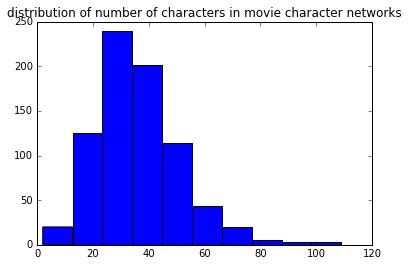

In [318]:
plt.hist(data[:, 1])
plt.title("distribution of number of characters of movie character networks")
plt.show()

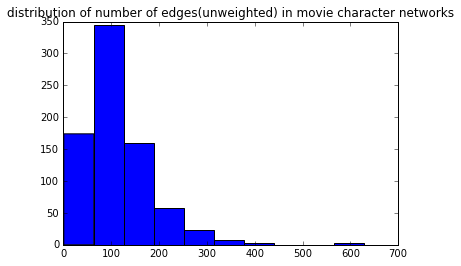

In [320]:
plt.hist(data[:, 2])
plt.title("distribution of number of edges(unweighted) of movie character networks")
plt.show()

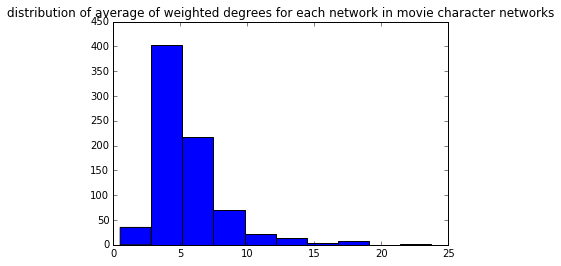

In [321]:
plt.hist(data[:, 5])
plt.title("distribution of average of weighted degrees for each network in movie character networks")
plt.show()

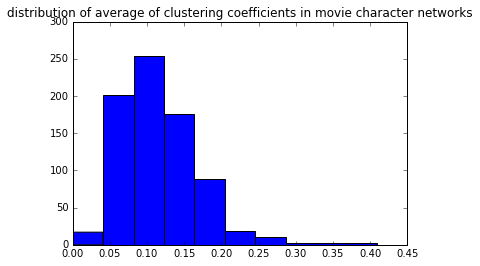

In [322]:
plt.hist(data[:, 6])
plt.title("distribution of average of clustering coefficients of movie character networks")
plt.show()

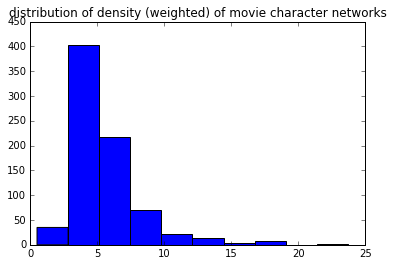

In [329]:
plt.hist(data[:, 7])
plt.title("distribution of density (weighted) of movie character networks")
plt.show()

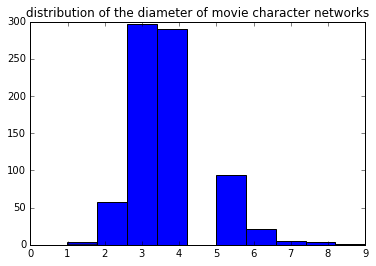

In [330]:
plt.hist(data[:, 8])
plt.title("distribution of the diameter of movie character networks")
plt.show()

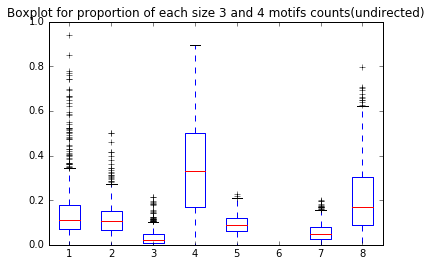

In [384]:
std = np.std(data[:, 10:], axis = 1)
mean = np.mean(data[:, 10:], axis = 1)
total = np.sum(data[:, 10:], axis = 1)
motfi_count_normalized = np.zeros((len(data), 8))
motfi_count_normalized[:, :] = data[:, 10:]
for i in range(len(motfi_count_normalized)):
    if std[i] == 0:
        continue
    motfi_count_normalized[i, :] = motfi_count_normalized[i, :]/ total[i]
fig, axes = plt.subplots()
axes.set_title("Boxplot for proportion of each size 3 and 4 motifs counts(undirected)")
axes.boxplot(motfi_count_normalized)
plt.show()